In [5]:
from __future__ import annotations
from typing import Union, Literal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import urllib.request as url
import pytz
import os
from IPython.display import display as ipdisplay
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings


import sys
sys.path.append('..')
from data_processing.data_import import Elmy_import
from stationarity.difference import difference, difference_of_seasonal_difference, seasonal_difference
from stationarity.stationarity_tests import ndiffs_needed, is_stationary

In [6]:
X_test = Elmy_import('../data/processed/X_test.csv', with_date=False)
y_train_raw = Elmy_import('../data/raw/y_train_raw.csv', with_date=False)
X_train = Elmy_import('../data/processed/X_train.csv', with_date=False)

In [7]:
X_train

,predicted_spot_price,Date (UTC),Date,TMin (°C),TMax (°C),Pic journalier consommation (MW),Température référence (°C),Solde min (MW),Solde max (MW),TMoy (°C),...,Consommation brute électricité (MW) - RTE,wind_power_forecasts_std,solar_power_forecasts_std,coal_power_available,gas_power_available,nucelear_power_available,Production horaire de biométhane (MWh - 0°C PCS),Consommation brute gaz totale (MW PCS 0°C),Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
DELIVERY_START,,,,,,,,,,,,,,,,,,,,,
2022-01-01 02:00:00+01:00,NaN,2022-01-01 01:00:00+00:00,2022-01-01,5.046667,14.886979,55828.0,4.6,817.0,11247.0,9.833385,...,51279.0,79.248348,0.000000,3386.0,11487.0,44118.0,128.201328,45584.0,7.754615,0.000000
2022-01-01 03:00:00+01:00,NaN,2022-01-01 02:00:00+00:00,2022-01-01,5.046667,14.886979,55828.0,4.6,817.0,11247.0,9.833385,...,48288.0,61.776532,0.000000,3386.0,11487.0,44118.0,124.860509,46671.0,7.754615,0.000000
2022-01-01 04:00:00+01:00,NaN,2022-01-01 03:00:00+00:00,2022-01-01,5.046667,14.886979,55828.0,4.6,817.0,11247.0,9.833385,...,46282.0,44.291112,0.000000,3386.0,11487.0,44118.0,127.018472,48808.0,7.754615,0.000000
2022-01-01 05:00:00+01:00,NaN,2022-01-01 04:00:00+00:00,2022-01-01,5.046667,14.886979,55828.0,4.6,817.0,11247.0,9.833385,...,46059.0,36.127588,0.000000,3386.0,11487.0,44118.0,121.807973,53658.0,7.699170,0.000000
2022-01-01 06:00:00+01:00,NaN,2022-01-01 05:00:00+00:00,2022-01-01,5.046667,14.886979,55828.0,4.6,817.0,11247.0,9.833385,...,46588.0,30.983023,0.000000,3386.0,11487.0,44118.0,135.582119,62758.0,7.641866,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,108.11,2023-03-29 17:00:00+00:00,2023-03-29,7.391042,20.721458,58250.0,9.8,-1041.0,11106.0,14.028073,...,51781.0,247.408490,7.821622,3386.0,11952.0,38320.0,164.616748,46591.0,7.743840,283.208205
2023-03-29 20:00:00+02:00,125.66,2023-03-29 18:00:00+00:00,2023-03-29,7.391042,20.721458,58250.0,9.8,-1041.0,11106.0,14.028073,...,51992.0,155.795012,2.534054,3386.0,11952.0,38320.0,163.582348,46060.0,7.728462,220.296923
2023-03-29 21:00:00+02:00,138.01,2023-03-29 19:00:00+00:00,2023-03-29,7.391042,20.721458,58250.0,9.8,-1041.0,11106.0,14.028073,...,49761.0,126.884684,0.000000,3386.0,11952.0,38320.0,158.597029,42420.0,7.722314,147.040513


In [8]:
def add_date_features(df: pd.DataFrame, date_column='Date (UTC)'):
    df[date_column] = pd.to_datetime(df[date_column])
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['month'] = df[date_column].dt.month
    df['quarter'] = df[date_column].dt.quarter
    df['year'] = df[date_column].dt.year
    df['hour_of_day'] = df[date_column].dt.hour
    df['time_of_day'] = pd.cut(df['hour_of_day'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])
    df = pd.get_dummies(df, columns=['time_of_day'], prefix='time_of_day', drop_first=True, dtype=float)  # One-hot encode 'time_of_day'
    df['season'] = (df['month'] % 12 + 3) // 3 # 1:spring, 2:summer, 3:fall, 4:winter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [9]:
X_train = add_date_features(X_train)
X_test = add_date_features(X_test)

<Axes: xlabel='DELIVERY_START'>

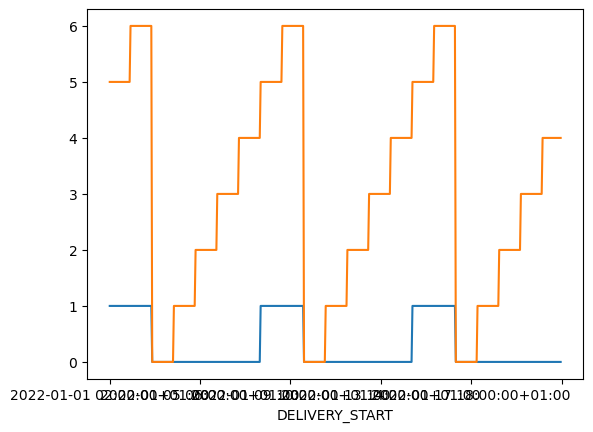

In [10]:
X_train['is_weekend'].iloc[:500].plot()
X_train['day_of_week'].iloc[:500].plot()

In [12]:
X_test.isna().sum()

predicted_spot_price                                0
Date (UTC)                                          0
Date                                                0
TMin (°C)                                           0
TMax (°C)                                           0
Pic journalier consommation (MW)                    0
Température référence (°C)                          0
Solde min (MW)                                      0
Solde max (MW)                                      0
TMoy (°C)                                           0
wind_power_forecasts_average                        0
solar_power_forecasts_average                       0
Consommation brute électricité (MW) - RTE           0
wind_power_forecasts_std                            0
solar_power_forecasts_std                           0
coal_power_available                                0
gas_power_available                                 0
nucelear_power_available                            0
Production horaire de biomét

In [13]:
import os
os.getcwd()

'c:\\Tim\\MVA\\S2\\Apprentissage et génération par échantillonnage aléatoire - challenge élec\\Test\\Elmy\\notebooks'